<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
<br>    
    
<div style="font-weight: 700; font-size: 20px;"> Open Machine Learning Course [mlcourse.ai](https://mlcourse.ai) </div>

<br>
<center>

Auteur : Vitaly Radchenko (@vradchenko). Traduit par : [Ousmane Cissé](https://github.com/oussou-dev.com) .Ce matériel est soumis aux termes et conditions de la licence [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). L'utilisation gratuite est autorisée à des fins non commerciales.</center></center>

<div style="font-weight: 700; font-size: 30px;"> <center>Mission # 5 (démo) </center> </div>

<br>

<div style="font-weight: 700; font-size: 23px;"> <center><center>Régression logistique et forêt aléatoire dans un problème de "credit scoring"</center> </center> </div>


Dans cette affectation, vous allez construire des modèles et répondre aux questions en utilisant des données sur la notation de crédit.

Veuillez écrire votre code dans les cellules ci-dessous ("Your code here"). Ensuite, répondez aux questions du [formulaire](https://docs.google.com/forms/d/1gKt0DA4So8ohKAHZNCk58ezvg7K_tik26d9QND7WC6M/edit).

Commençons par un exercice d'échauffement.

**Question 1.** Il y a 5 jurés dans une salle d'audience. Chacun d'entre eux peut identifier correctement la culpabilité du défendeur avec une probabilité de 70%, indépendamment l'un de l'autre. Quelle est la probabilité que les jurés parviennent conjointement au verdict correct si la décision finale est prise à la majorité des voix?

1. 70,00%
2. 83,20%
3. 83,70%
4. 87,50%

Génial! Passons à l'apprentissage automatique.

## Présentation du problème de "credit scoring"

### Problème

Prédisez si le client remboursera son crédit dans les 90 jours. Ceci est un problème de classification binaire; nous allons affecter les clients dans les bonnes ou les mauvaises catégories en fonction de nos prévisions.

### Description des données


| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Mettons en place notre environnement:

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Écrivons la fonction qui remplacera *NaN* par la médiane de chaque colonne.

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Maintenant, lisez les données:

In [4]:
data = pd.read_csv('../input/credit_scoring_sample.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Regardez les types de variables:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Vérifiez le solde de la classe:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

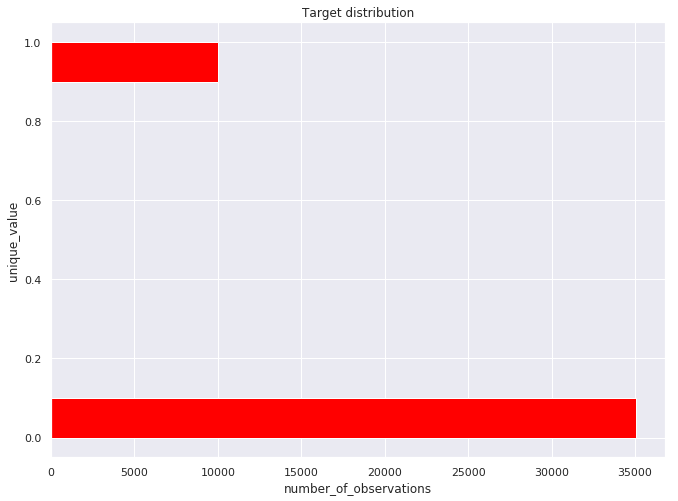

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Séparez les noms de variables d'entrée en excluant la cible:

In [7]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Appliquez la fonction pour remplacer les valeurs *NaN*:

In [8]:
table = fill_nan(data)

Séparez la variable cible et les caractéristiques en entrée:

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 2.** Faire une estimation par intervalle de l'âge moyen des clients qui ont retardé le remboursement à un niveau de confiance de 90 %. Utilisez l'exemple de l'article comme référence, si nécessaire. Aussi, utilisez `np.random.seed(0)` comme précédemment. Quelle est l'estimation de l'intervalle qui en résulte ?

1. 52.59 - 52.86
2. 45,71 - 46,13
3. 45,68 - 46,17
4. 52,56 - 52,88

In [10]:
# Your code here

## Régression logistique

Préparons-nous à utiliser la régression logistique :

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Maintenant, nous allons créer un modèle `LogisticRegression` et utiliser `class_weight='balanced'` pour compenser nos classes déséquilibrées.

In [12]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Essayons de trouver le meilleur coefficient de régularisation, qui est le coefficient `C` pour la régression logistique. Ensuite, nous aurons un modèle optimal qui n’est pas sur-ajusté et qui est un bon prédicteur de la variable cible.

In [13]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

Afin de trouver la valeur optimale de `C`, appliquons une validation stratifiée à 5 niveaux (5-fold) et examinons le _ROC AUC_ par rapport à différentes valeurs du paramètre` C`. Utilisez la fonction `StratifiedKFold` pour cela :

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

L'une des métriques importantes de la qualité du modèle est la *zone sous la courbe (AUC)*. Le *ROC AUC* varie de 0 à 1. Plus le ROC AUC est proche de 1, meilleure est la qualité du modèle de classification.

**Question 3.** Effectuez une *Grid Search* avec la métrique de scoring "roc_auc" pour le paramètre `C`. Quelle valeur du paramètre `C` est optimale ?

1. 0,0001
2. 0,001
3. 0,01
4. 0,1
5. 1
6. 10

In [15]:
# Your code here

**Question 4.** Peut-on considérer le meilleur modèle stable? Le modèle est *stable* si l'écart type lors de la validation est inférieur à 0,5%. Enregistrez la valeur *ROC AUC* du meilleur modèle. Cela sera utile pour les tâches suivantes.

1. oui
2. non

In [16]:
# Your code here

## Importance des caractéristiques (Feature Importance)

**Question 5.** _L'importance d'une caractéristique_ est définie par la valeur absolue de son coefficient correspondant. Tout d'abord, vous devez normaliser toutes les valeurs des caractéristiques pour qu'il soit valide de les comparer. Quelle est la caractéristique la plus importante pour le meilleur modèle de régression logistique ?
1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [17]:
# Your code here

**Question 6.** Calculez l'impact de `DebtRatio` sur notre prédiction à l'aide de la [fonction softmax](https://en.wikipedia.org/wiki/Softmax_function). Quelle est sa valeur?

1. 0.38
2. -0.02
3. 0.11
4. 0.24

In [18]:
# Your code here

**Question 7.** Voyons comment nous pouvons interpréter l’impact de nos caractéristiques. Pour cela, recalculez la régression logistique avec des valeurs absolues, c'est-à-dire sans mise à l'échelle. Ensuite, modifiez l'âge du client en ajoutant 20 ans, en laissant les autres caractéristiques inchangées. Combien de fois le risque que le client ne rembourse pas sa dette augmente-t-il? Vous pouvez trouver un exemple de calcul théorique [ici](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. 0.70
3. 8.32
4. 0.66

In [19]:
# Your code here

## Forêt aléatoire (random forest)

Importez le classifieur Forêt aléatoire:

In [20]:
from sklearn.ensemble import RandomForestClassifier

Initialiser une forêt aléatoire avec 100 arbres et équilibrer les classes cibles:

In [21]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, 
                            class_weight='balanced')

Nous rechercherons les meilleurs paramètres parmi les valeurs suivantes:

In [22]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}

Nous allons également utiliser à nouveau la validation stratifiée à k-fold. Vous devriez toujours avoir la variable `skf`.

**Question 8.** De combien, la *ROC AUC* du meilleur modèle de forêt aléatoire est-elle supérieure à celle de la meilleure régression logistique après validation?

1. 4%
2. 3%
3. 2%
4. 1%

In [23]:
# Your code here

**Question 9.** Quelle caractéristique a l’impact le plus faible dans le modèle de forêt aléatoire?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

In [24]:
# Your code here

**Question 10.** Quel est l'avantage le plus significatif de l'utilisation de la *Régression logistique* par rapport à la *Forêt aléatoire* pour résoudre ce problème?

1. passé moins de temps pour l'ajustement du modèle;
2. Moins de variables à itérer;
3. interprétabilité des caractéristiques;
4. Propriétés linéaires de l'algorithme.

## Bagging (Ensachage)

Importer des modules et configurer les paramètres pour le Bagging :

In [25]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Installez un classifieur bagging avec `random_state = 42`. Pour les classifieurs de base, utilisez 100 régresseurs logistiques et utilisez `RandomizedSearchCV` au lieu de `GridSearchCV`. Il faudra beaucoup de temps pour parcourir les 54 variantes, donc définissez le nombre maximal d'itérations pour `RandomizedSearchCV` sur 20. N'oubliez pas de définir les paramètres `cv` et `random_state=1`. Quel est le meilleur *ROC AUC* que vous obtenez ?

1. 80,75%
2. 80,12%
3. 79,62%
4. 76,50%

In [26]:
# Your code here

**Question 12.** Donnez une interprétation des meilleurs paramètres pour le Bagging. Pourquoi ces valeurs de `max_features` et de` max_samples` sont-elles les meilleures?

1. Pour le bagging, il est important d'utiliser le moins de caractéristiques possible.
2. Le bagging fonctionne mieux sur de petits échantillons.
3. Moins de corrélation entre les modèles individuels;
4. Plus le nombre de caractéristiques est élevé, plus la perte d'informations est faible.